## Imitative Learning: IL in Pendulum

In [1]:
import gym

# 定义环境
class MyWrapper(gym.Wrapper):
  def __init__(self):
    env = gym.make('Pendulum-v1', render_mode='rgb_array')
    super().__init__(env)
    self.env = env
    self.step_n = 0
  
  def reset(self):
    state, _ = self.env.reset()
    self.step_n = 0
    return state
    
  def step(self, action):
    state, reward, terminated, truncated, info = self.env.step(action)
    done = terminated or truncated
    self.step_n += 1
    if self.step_n >= 200:
      done = True
    return state, reward, done, info 
  
env = MyWrapper()
env.reset()

array([-0.1670376 ,  0.9859505 , -0.00312404], dtype=float32)

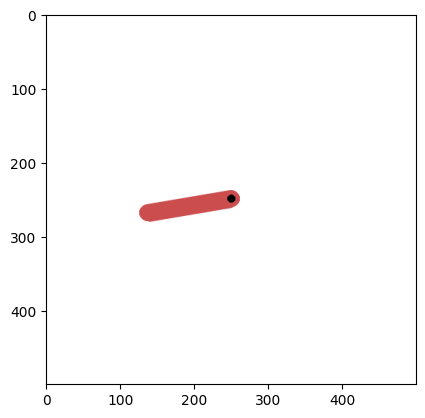

In [2]:
from matplotlib import pyplot as plt

%matplotlib inline

# 打印游戏
def show():
  plt.imshow(env.render())
  plt.show()
  
show()

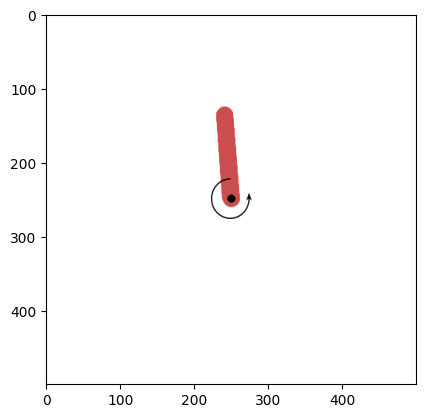

(0.4911009669303894, -1434.963844743415)

In [6]:
import torch
import random
from IPython import display

# 教师模型使用PPO
class Model(torch.nn.Module):
	def __init__(self):
		super().__init__()
		# 定义模型
		self.fc_statu = torch.nn.Sequential(
			torch.nn.Linear(3, 128),
			torch.nn.ReLU(),
		)

		self.fc_mu = torch.nn.Sequential(
			torch.nn.Linear(128, 1),
			torch.nn.Tanh(),
		)

		self.fc_std = torch.nn.Sequential(
			torch.nn.Linear(128, 1),
			torch.nn.Softplus(),
		)

	def forward(self, state):
		state = self.fc_statu(state)
		mu = self.fc_mu(state) * 2.0
		std = self.fc_std(state)

		return mu, std
  
class PPO:
  
	def __init__(self):
		# 定义模型
		self.model = Model()
		self.model_td = torch.nn.Sequential(
			torch.nn.Linear(3, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 1),
		)

		self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
		self.optimizer_td = torch.optim.Adam(self.model_td.parameters(), lr=5e-3)
		self.loss_fn = torch.nn.MSELoss()
  
  # 得到一个动作
	def get_action(self, state):
		# 走神经网络，得到一个动作
		state = torch.FloatTensor(state).reshape(1, 3)
		# [1, 4] -> [1, 2]
		mu, std = self.model(state)
		
		# 根据概率选择一个动作
		# action = random.choices(range(2), weights=prob[0].tolist(), k=1)[0]
		action = torch.distributions.Normal(mu, std).sample().item()
  
		return action

	# 得到一局游戏的数据
	def get_data(self):
		states = []
		rewards = []
		actions = []
		next_states = []
		overs = []
		
		
		# 初始化游戏
		state = env.reset()
		
		# 玩到游戏结束为止
		over = False
		while not over:
			# 根据当前状态得到一个动作
			action = self.get_action(state)
			
			# 执行动作，得到反馈
			next_state, reward, over, _ = env.step([action])
			
			# 记录数据样本
			states.append(state)
			rewards.append(reward)
			actions.append(action)
			next_states.append(next_state)
			overs.append(over)
			
			# 更新游戏状态，开始下一个动作
			state = next_state
			
		# [b, 4]
		states = torch.FloatTensor(states).reshape(-1, 3)
		# [b, 1]
		rewards = torch.FloatTensor(rewards).reshape(-1, 1)
		# [b, 1]
		actions = torch.FloatTensor(actions).reshape(-1, 1)
		# [b, 4]
		next_states = torch.FloatTensor(next_states).reshape(-1, 3)
		# [b, 1]
		overs = torch.LongTensor(overs).reshape(-1, 1)
		
		return states, rewards, actions, next_states, overs

	def test(self, play):
		#初始化游戏
		state = env.reset()
		
		#记录反馈值的和,这个值越大越好
		reward_sum = 0
		
		#玩到游戏结束为止
		over = False
		while not over:
			#根据当前状态得到一个动作
			action = self.get_action(state)
			
			#执行动作,得到反馈
			state, reward, over, _ = env.step([action])
			reward_sum += reward
			
			# 打印动画
			if play and random.random() < 0.2: # 跳帧
				display.clear_output(wait=True)
				show()
				
		return reward_sum

	# 优势函数
	def _get_advantages(self, deltas):
		advantages = []
		
		# 反向遍历deltas
		s = 0.0
		for delta in deltas[::-1]:
			s = 0.9 * 0.9 * s + delta
			advantages.append(s)
			
		# 逆序
		advantages.reverse()
		return advantages

	def train(self, states, rewards, actions, next_states, overs):
		# 偏移reward, 便于训练
		rewards = (rewards + 8) / 8
	
		# 计算values, targets
		# [b, 3] -> [b, 1]
		values = self.model_td(states)
		
		# [b, 3] -> [b, 1]
		targets = self.model_td(next_states).detach()
		targets = targets * 0.98
		targets *= (1 - overs)
		targets += rewards
		
		# 计算优势,这里的advantages有点像是策略梯度里的reward_sum
    # 只是这里计算的不是reward,而是target和value的差
		# [b, 1]
		deltas = (targets - values).squeeze(dim=1).tolist()
		advantages = self._get_advantages(deltas)
		advantages = torch.FloatTensor(advantages).reshape(-1, 1)
		
		# 取出每步动作的概率
		# [b, 3] -> [b, 1],[b, 1]
		mu, std = self.model(states)
		# [b, 1] 
		old_probs = torch.distributions.Normal(mu, std)
		old_probs = old_probs.log_prob(actions).exp().detach()
		
		# 每个批量反复训练10次
		for _ in range(10):
			# 重新计算每一步动作的概率
			# [b, 3] -> [b, 1],[b, 1]
			mu, std = self.model(states)
			
			# [b, 1]
			new_probs = torch.distributions.Normal(mu, std)
			new_probs = new_probs.log_prob(actions).exp()
			
			# 求出概率变化
			# [b, 1] - [b, 1] -> [b, 1]
			ratios = new_probs / old_probs
			
			# 计算截断和不接段的两份loss, 取小的
			# [b, 1] * [b, 1] -> [b, 1]
			surr1 = ratios * advantages
			# [b, 1] * [b, 1] -> [b, 1]
			surr2 = torch.clamp(ratios, 0.8, 1.2) * advantages
			
			loss = -torch.min(surr1, surr2)
			loss = loss.mean()
			
			# 重新计算value和时序差分
			values = self.model_td(states)
			loss_td = self.loss_fn(values, targets.detach())
			
			# 更新参数
			self.optimizer.zero_grad()
			loss.backward()
			self.optimizer.step()
			
			self.optimizer_td.zero_grad()
			loss_td.backward()
			self.optimizer_td.step()

teacher = PPO()

teacher.train(*teacher.get_data())

teacher.get_action([1, 2, 3]), teacher.test(play=True)

In [7]:
for i in range(6000):
  teacher.train(*teacher.get_data())
  
  if i % 500 == 0:
    test_result = sum([teacher.test(play=False) for _ in range(10)]) / 10
    print(i, test_result)
    
teacher.test(play=False)

0 -1467.9182524682278
500 -1026.235160767892
1000 -846.9602784434285
1500 -791.1909766823553
2000 -234.67914328274986
2500 -606.2074787818119
3000 -283.9636230962822
3500 -403.9531178763735
4000 -260.7852205296382
4500 -203.51747635389287
5000 -223.9104561987594
5500 -453.75639094014497


-129.24272953488318

In [8]:
# 使用训练好的模型获取一批教师数据
# teacher_states, _, teacher_actions, _, _ = teacher.get_data()

# # 删除教师，只留下教师的数据就可以了
# del teacher

# teacher_states.shape, teacher_actions.shape

In [9]:
# 初始化学生模型
student = PPO()

student

In [10]:
# 定义鉴别器网络，鉴定一批数据来自teacher还是student
class Discriminator(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.sequential = torch.nn.Sequential(
			torch.nn.Linear(4, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 1),
			torch.nn.Sigmoid(),
		)
    
  def forward(self, states, actions):
    cat = torch.cat([states, actions], dim=1)
    return self.sequential(cat)
  
discriminator = Discriminator()
discriminator(torch.randn(2, 3), torch.randn(2, 1))

tensor([[0.4116],
        [0.4133]], grad_fn=<SigmoidBackward0>)

In [12]:
# 模仿学习
def imi_learn():
  optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-3)
  bce_loss = torch.nn.BCELoss()
  
  for i  in range(20000):
    #使用训练好的模型获取一批教师数据
    with torch.no_grad():
      teacher_states, _, teacher_actions, _, _ = teacher.get_data()
      
    # 使用Student模型获取一句游戏的数据，不需要reward
    states, _, actions, next_states, overs = student.get_data()
    
    # 使用鉴别器鉴定两批数据的来源
    prob_teacher = discriminator(teacher_states, teacher_actions)
    prob_student = discriminator(states, actions)
    
    # 老师0，学生1，计算二分类loss
    loss_teacher = bce_loss(prob_teacher, torch.zeros_like(prob_teacher))
    loss_student = bce_loss(prob_student, torch.ones_like(prob_student))
    loss = loss_teacher + loss_student
    
    # 调整鉴别器
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # 使用一批数据来自学生的概率作为reward,取log,再符号取反
    # 因为鉴别器会把学生数据的概率贴近1,所以目标是让鉴别器无法分辨,这是一种对抗网络的思路
    rewards = -prob_student.log().detach()
    
    # 消除模型中reward偏移
    rewards = rewards * 8 - 8
    
    # 更新学生模型参数,使用PPO模型本身的更新方式
    student.train(states, rewards, actions, next_states, overs)
    
    if i % 500 == 0:
      test_result = sum([student.test(play=False) for _ in range(10)]) / 10
      print(i, test_result)
      
imi_learn()

0 -1091.0237938032947
500 -796.0676713060788
1000 -487.0981558064067
1500 -385.6273912898046
2000 -329.6237126713896
2500 -571.0229324748318
3000 -762.7206487031491
3500 -593.4407173620395
4000 -225.75847406634654
4500 -564.6573307759596
5000 -475.94372739062345
5500 -210.36022811779912
6000 -396.3382141752695
6500 -357.41760472769533
7000 -286.68580052559753
7500 -369.63717632683154
8000 -223.50062705605995
8500 -424.453621712881
9000 -211.17240857864627
9500 -168.5075723366022
10000 -423.3808219999113
10500 -316.771882874716
11000 -741.5991516145277
11500 -292.51651786307855
12000 -539.1569266821782
12500 -318.5252306929846
13000 -434.4081511754263
13500 -223.07811073639542
14000 -387.991451229187
14500 -471.97400327251705
15000 -243.58421667249044
15500 -198.69883104129715
16000 -249.20695928267423
16500 -220.3196588192788
17000 -657.4817188202938
17500 -732.9497119834148
18000 -220.01413193840472
18500 -120.24537506436972
19000 -272.743758890207
19500 -177.78945234473142


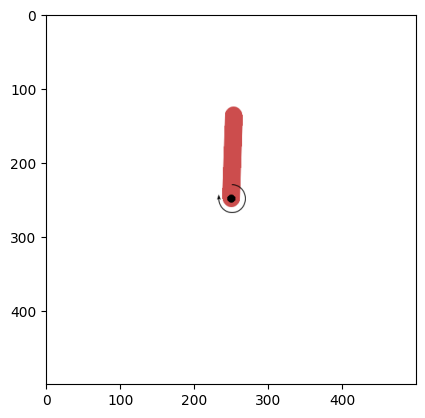

-128.16508216178687

In [13]:
student.test(play=True)